# Age-Specific Propensity Supply Forecasts

Colleen Anh Nepomuceno

This notebook is used to generate supply forecasts in the PH with regional granularity.

* The approach is based from the paper of Zhang et.al. (2020).
* Link to Paper: https://human-resources-health.biomedcentral.com/articles/10.1186/s12960-020-0448-3 
* Only modification to model proposed by paper is that we also made propensity dependent on the region to gain more accurate forecasts.

In [1]:
# Import packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates

from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-wbm4i8su because the default path (/home/jjayme/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Load files

In [2]:
# Update filepaths if needed
path_doctor = '../data/processed/2010-20_doctor_demographics.csv'
path_pop = '../data/processed/Projected_age_population.csv'

In [3]:
# Load datasets
data_doctor = pd.read_csv(path_doctor)
data_pop = pd.read_csv(path_pop)

## Data Pre-processing

In [4]:
# Region name mapping
region_new_name_map = {'NATIONAL CAPITAL REGION (NCR)': 'NCR',
                       'CORDILLERA ADMINISTRATIVE REGION (CAR)': 'CAR',
                       'REGION I (ILOCOS REGION)': 'I - Ilocos',
                       'REGION II (CAGAYAN VALLEY)': 'II - Cagayan',
                       'REGION III (CENTRAL LUZON)': 'III - C. Luzon',
                       'REGION IV-A (CALABARZON)': 'IVA - Calabarzon',
                       'REGION IVA - CALABARZON': 'IVA - Calabarzon',
                       'MIMAROPA REGION': 'MIMAROPA',
                       'REGION V (BICOL REGION)': 'V - Bicol',
                       'REGION VI (WESTERN VISAYAS)': 'VI - W. Visayas',
                       'REGION VII (CENTRAL VISAYAS)': 'VII - C. Visayas',
                       'REGION VIII (EASTERN VISAYAS)': 'VIII - E. Visayas',
                       'REGION IX (ZAMBOANGA PENINSULA)': 'IX - Zamboanga',
                       'REGION X (NORTHERN MINDANAO)': 'X - N. Mindanao',
                       'REGION XI (DAVAO REGION)': 'XI - Davao',
                       'REGION XII (SOCCSKSARGEN)': 'XII - SOCCSKSARGEN',
                       'REGION XIII (Caraga)': 'XIII - Caraga',
                       'AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)': 'BARMM',
                       'BANGSAMORO AUTONOMOUS REGION IN MUSLIM MINDANAO (BARMM)': 'BARMM',
                       'NO INFO': 'NO INFO', 
                       'ARMM / BARMM': 'BARMM'
                       }

In [5]:
# Rename region names to be consistent with other datasets
data_doctor['Region'] = data_doctor['Region'].map(region_new_name_map)

# Rename region names to be consistent with other datasets
data_pop['Region'] = data_pop['Region'].map(region_new_name_map)

### Prepare doctor dataset

In [6]:
data_doctor.sample(5)

,Year,Region,Type,Sub-type,Total
124,2010,BARMM,Age,No info,1.0
405,2013,VII - C. Visayas,Age,25-34,4.0
2716,2018,BARMM,Ownership type,Private,12.0
272,2012,I - Ilocos,Age,25-34,3.0
2479,2011,XI - Davao,Ownership type,Public,217.0


In [7]:
# Filter rows only for age distribution
data_doctor = data_doctor.loc[data_doctor['Type']=='Age']

# Remove rows for NO INFO
data_doctor = data_doctor.loc[data_doctor['Region']!='NO INFO']

In [8]:
# Convert Year column to int
data_doctor.Year.astype('int')

# Pivot table
data_doctor = (data_doctor.pivot(index=['Region', 'Year'],
                                  columns=['Type', 'Sub-type'],
                                  values='Total').reset_index())

In [9]:
# Flatten the column names
data_doctor.columns = ['_'.join(col) for col in data_doctor.columns.values]

In [10]:
# Rename columns
data_doctor.rename(columns = {'Region_': 'Region', 'Year_': 'Year'},
                    inplace=True)
data_doctor.head()

,Region,Year,Age_<25,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65 and above,Age_No info
0,BARMM,2010,0.0,0.0,16.0,15.0,20.0,9.0,1.0
1,BARMM,2011,0.0,0.0,16.0,14.0,20.0,9.0,1.0
2,BARMM,2012,0.0,0.0,17.0,13.0,20.0,8.0,1.0
3,BARMM,2013,0.0,0.0,17.0,13.0,20.0,10.0,1.0
4,BARMM,2014,0.0,6.0,18.0,13.0,20.0,10.0,1.0


### Prepare population dataset

In [11]:
data_pop.sample(5)

,Unnamed: 0,year,Region,Age,population
98,5,2015,BARMM,65-69,29823.0
1636,12,2022,I - Ilocos,25-29,416184.0
875,9,2019,MIMAROPA,45-49,151282.0
3388,10,2020,V - Bicol,30-34,427129.0
4943,17,2027,X - N. Mindanao,65-69,149048.0


In [12]:
data_pop.drop('Unnamed: 0', axis=1, inplace=True)
data_pop.rename(columns={'population':'Age_', 'year':'Year'}, inplace=True)

In [13]:
data_pop.sample(5)

,Year,Region,Age,Age_
4839,2021,X - N. Mindanao,55-59,194606.0
4873,2023,X - N. Mindanao,55-59,204646.0
3814,2024,VI - W. Visayas,35-39,562393.0
1795,2010,II - Cagayan,50-54,149700.0
1385,2028,NCR,45-49,978636.0


In [14]:
data_pop = (data_pop.pivot(index=['Region', 'Year'], columns='Age')
            .reset_index())

In [15]:
# Flatten the column names
data_pop.columns = [''.join(col) for col in data_pop.columns.values]

In [16]:
data_pop.head()

,Region,Year,Age_0-4,Age_10-14,Age_15-19,Age_20-24,Age_25-29,Age_30-34,Age_35-39,Age_40-44,Age_45-49,Age_5-9,Age_50-54,Age_55-59,Age_60-64,Age_65-69,Age_70-74,Age_75-79,Age_80 and over
0,BARMM,2010,466700.0,454000.0,389200.0,269500.0,229600.0,228600.0,203000.0,174400.0,137700.0,465700.0,89600.0,62100.0,40500.0,26000.0,14800.0,7000.0,5700.0
1,BARMM,2011,480600.4,462938.6,395500.8,280705.6,241336.2,232471.6,211318.0,179865.2,142810.8,483233.0,93626.8,64253.0,41732.6,26764.6,15346.0,7494.4,6253.2
2,BARMM,2012,494500.8,471877.2,401801.6,291911.2,253072.4,236343.2,219636.0,185330.4,147921.6,500766.0,97653.6,66406.0,42965.2,27529.2,15892.0,7988.8,6806.4
3,BARMM,2013,508401.2,480815.8,408102.4,303116.8,264808.6,240214.8,227954.0,190795.6,153032.4,518299.0,101680.4,68559.0,44197.8,28293.8,16438.0,8483.2,7359.6
4,BARMM,2014,522301.6,489754.4,414403.2,314322.4,276544.8,244086.4,236272.0,196260.8,158143.2,535832.0,105707.2,70712.0,45430.4,29058.4,16984.0,8977.6,7912.8


In [17]:
data_pop.Year = data_pop.Year.astype('int')

In [18]:
# Prepare regional aggregation of population
regional_pop = data_pop.copy()
cols = ['Age_0-4', 'Age_10-14', 'Age_15-19', 'Age_20-24',
       'Age_25-29', 'Age_30-34', 'Age_35-39', 'Age_40-44', 'Age_45-49',
       'Age_5-9', 'Age_50-54', 'Age_55-59', 'Age_60-64', 'Age_65-69',
       'Age_70-74', 'Age_75-79', 'Age_80 and over']
regional_pop['Population'] = regional_pop[cols].sum(axis=1)
regional_pop = regional_pop[['Region', 'Year', 'Population']]
regional_pop.head()

,Region,Year,Population
0,BARMM,2010,3264100.0
1,BARMM,2011,3366250.8
2,BARMM,2012,3468401.6
3,BARMM,2013,3570552.4
4,BARMM,2014,3672703.2


In [21]:
regional_pop.to_csv('~/cpt5/capstone/data/processed/2010-30_PSA_regional_'
                    'population.csv')

### Align age distribution of two datasets

In [22]:
data_doctor.iloc[:, 2:].sum(axis=0)

Age_<25               297.0
Age_25-34           14280.0
Age_35-44           72183.0
Age_45-54           74019.0
Age_55-64           59440.0
Age_65 and above    62510.0
Age_No info          8494.0
dtype: float64

**Important Note:** 2.9% (8494 out of 291280) of physician population do not have information on age. We set this as a limitation in this approach.

In [23]:
# Alignment of age range
data_pop['Pop_Age_<25'] = (data_pop[['Age_0-4', 'Age_5-9', 'Age_10-14',
                                   'Age_15-19', 'Age_20-24']].sum(axis=1))
data_pop['Pop_Age_25-34'] = data_pop[['Age_25-29', 'Age_30-34']].sum(axis=1)
data_pop['Pop_Age_35-44'] = data_pop[['Age_35-39', 'Age_40-44']].sum(axis=1)
data_pop['Pop_Age_45-54'] = data_pop[['Age_45-49', 'Age_50-54']].sum(axis=1)
data_pop['Pop_Age_55-64'] = data_pop[['Age_55-59', 'Age_60-64']].sum(axis=1)
data_pop['Pop_Age_65 and above'] = (data_pop[['Age_65-69',
                                                'Age_70-74',
                                                'Age_75-79',
                                                'Age_80 and over']]
                                     .sum(axis=1))

In [24]:
# Retain relevant columns only
data_pop = data_pop[['Region',
                       'Year',
                       'Pop_Age_<25',
                       'Pop_Age_25-34',
                       'Pop_Age_35-44',
                       'Pop_Age_45-54',
                       'Pop_Age_55-64',
                       'Pop_Age_65 and above']]

In [25]:
data_doctor.head()

,Region,Year,Age_<25,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65 and above,Age_No info
0,BARMM,2010,0.0,0.0,16.0,15.0,20.0,9.0,1.0
1,BARMM,2011,0.0,0.0,16.0,14.0,20.0,9.0,1.0
2,BARMM,2012,0.0,0.0,17.0,13.0,20.0,8.0,1.0
3,BARMM,2013,0.0,0.0,17.0,13.0,20.0,10.0,1.0
4,BARMM,2014,0.0,6.0,18.0,13.0,20.0,10.0,1.0


In [26]:
data_pop.head()

,Region,Year,Pop_Age_<25,Pop_Age_25-34,Pop_Age_35-44,Pop_Age_45-54,Pop_Age_55-64,Pop_Age_65 and above
0,BARMM,2010,2045100.0,458200.0,377400.0,227300.0,102600.0,53500.0
1,BARMM,2011,2102978.4,473807.8,391183.2,236437.6,105985.6,55858.2
2,BARMM,2012,2160856.8,489415.6,404966.4,245575.2,109371.2,58216.4
3,BARMM,2013,2218735.2,505023.4,418749.6,254712.8,112756.8,60574.6
4,BARMM,2014,2276613.6,520631.2,432532.8,263850.4,116142.4,62932.8


In [27]:
data_pop.isnull().sum()

Region                  0
Year                    0
Pop_Age_<25             0
Pop_Age_25-34           0
Pop_Age_35-44           0
Pop_Age_45-54           0
Pop_Age_55-64           0
Pop_Age_65 and above    0
dtype: int64

## Getting the age and region-specific propensity scores

In [28]:
df_merge = (pd.merge(data_pop, data_doctor,
                  how='right',
                  left_on=['Region', 'Year'],
                  right_on=['Region', 'Year']))

In [29]:
df_merge.head(5)

,Region,Year,Pop_Age_<25,Pop_Age_25-34,Pop_Age_35-44,Pop_Age_45-54,Pop_Age_55-64,Pop_Age_65 and above,Age_<25,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65 and above,Age_No info
0,BARMM,2010,2045100.0,458200.0,377400.0,227300.0,102600.0,53500.0,0.0,0.0,16.0,15.0,20.0,9.0,1.0
1,BARMM,2011,2102978.4,473807.8,391183.2,236437.6,105985.6,55858.2,0.0,0.0,16.0,14.0,20.0,9.0,1.0
2,BARMM,2012,2160856.8,489415.6,404966.4,245575.2,109371.2,58216.4,0.0,0.0,17.0,13.0,20.0,8.0,1.0
3,BARMM,2013,2218735.2,505023.4,418749.6,254712.8,112756.8,60574.6,0.0,0.0,17.0,13.0,20.0,10.0,1.0
4,BARMM,2014,2276613.6,520631.2,432532.8,263850.4,116142.4,62932.8,0.0,6.0,18.0,13.0,20.0,10.0,1.0


In [30]:
df_merge.isnull().sum()

Region                  0
Year                    0
Pop_Age_<25             0
Pop_Age_25-34           0
Pop_Age_35-44           0
Pop_Age_45-54           0
Pop_Age_55-64           0
Pop_Age_65 and above    0
Age_<25                 0
Age_25-34               0
Age_35-44               0
Age_45-54               0
Age_55-64               0
Age_65 and above        0
Age_No info             1
dtype: int64

In [31]:
# Remove column of Age_no info
df_merge.drop(columns=['Age_No info'], inplace=True)

In [32]:
# Calculate propensity per age group
df_merge['propensity__<25'] = df_merge['Age_<25']/df_merge['Pop_Age_<25']
df_merge['propensity__25-34'] = df_merge['Age_25-34']/df_merge['Pop_Age_25-34']
df_merge['propensity__35-44'] = df_merge['Age_35-44']/df_merge['Pop_Age_35-44']
df_merge['propensity__45-54'] = df_merge['Age_45-54']/df_merge['Pop_Age_45-54']
df_merge['propensity__55-64'] = df_merge['Age_55-64']/df_merge['Pop_Age_55-64']
df_merge['propensity__65 and above'] = (df_merge['Age_65 and above']/
                                     df_merge['Pop_Age_65 and above'])

In [33]:
df_merge.head(5)

,Region,Year,Pop_Age_<25,Pop_Age_25-34,Pop_Age_35-44,Pop_Age_45-54,Pop_Age_55-64,Pop_Age_65 and above,Age_<25,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65 and above,propensity__<25,propensity__25-34,propensity__35-44,propensity__45-54,propensity__55-64,propensity__65 and above
0,BARMM,2010,2045100.0,458200.0,377400.0,227300.0,102600.0,53500.0,0.0,0.0,16.0,15.0,20.0,9.0,0.0,0.000000,0.000042,0.000066,0.000195,0.000168
1,BARMM,2011,2102978.4,473807.8,391183.2,236437.6,105985.6,55858.2,0.0,0.0,16.0,14.0,20.0,9.0,0.0,0.000000,0.000041,0.000059,0.000189,0.000161
2,BARMM,2012,2160856.8,489415.6,404966.4,245575.2,109371.2,58216.4,0.0,0.0,17.0,13.0,20.0,8.0,0.0,0.000000,0.000042,0.000053,0.000183,0.000137
3,BARMM,2013,2218735.2,505023.4,418749.6,254712.8,112756.8,60574.6,0.0,0.0,17.0,13.0,20.0,10.0,0.0,0.000000,0.000041,0.000051,0.000177,0.000165
4,BARMM,2014,2276613.6,520631.2,432532.8,263850.4,116142.4,62932.8,0.0,6.0,18.0,13.0,20.0,10.0,0.0,0.000012,0.000042,0.000049,0.000172,0.000159


### Plotting propensity scores

In [34]:
df_merge2 = df_merge[['Region', 'Year', 'propensity__<25',
                     'propensity__25-34', 'propensity__35-44',
                     'propensity__45-54', 'propensity__55-64',
                     'propensity__65 and above']]

In [35]:
df_merge2

,Region,Year,propensity__<25,propensity__25-34,propensity__35-44,propensity__45-54,propensity__55-64,propensity__65 and above
0,BARMM,2010,0.0,0.000000,0.000042,0.000066,0.000195,0.000168
1,BARMM,2011,0.0,0.000000,0.000041,0.000059,0.000189,0.000161
2,BARMM,2012,0.0,0.000000,0.000042,0.000053,0.000183,0.000137
3,BARMM,2013,0.0,0.000000,0.000041,0.000051,0.000177,0.000165
4,BARMM,2014,0.0,0.000012,0.000042,0.000049,0.000172,0.000159
...,...,...,...,...,...,...,...,...
182,XIII - Caraga,2016,0.0,0.000055,0.000394,0.000464,0.000677,0.000752
183,XIII - Caraga,2017,0.0,0.000053,0.000385,0.000459,0.000663,0.000728
184,XIII - Caraga,2018,0.0,0.000047,0.000261,0.000360,0.000528,0.000579
185,XIII - Caraga,2019,0.0,0.000036,0.000241,0.000375,0.000512,0.000603


In [36]:
df_merge_for_plot = df_merge2.melt(id_vars=['Region', 'Year'])
df_merge_for_plot['Age Group'] = (df_merge_for_plot['variable']
                                  .str.extract(r'propensity__(.*)'))
df_merge_for_plot

,Region,Year,variable,value,Age Group
0,BARMM,2010,propensity__<25,0.000000,<25
1,BARMM,2011,propensity__<25,0.000000,<25
2,BARMM,2012,propensity__<25,0.000000,<25
3,BARMM,2013,propensity__<25,0.000000,<25
4,BARMM,2014,propensity__<25,0.000000,<25
...,...,...,...,...,...
1117,XIII - Caraga,2016,propensity__65 and above,0.000752,65 and above
1118,XIII - Caraga,2017,propensity__65 and above,0.000728,65 and above
1119,XIII - Caraga,2018,propensity__65 and above,0.000579,65 and above
1120,XIII - Caraga,2019,propensity__65 and above,0.000603,65 and above


In [37]:
df_merge_for_plot['value_revised_unit'] = df_merge_for_plot['value']*10000

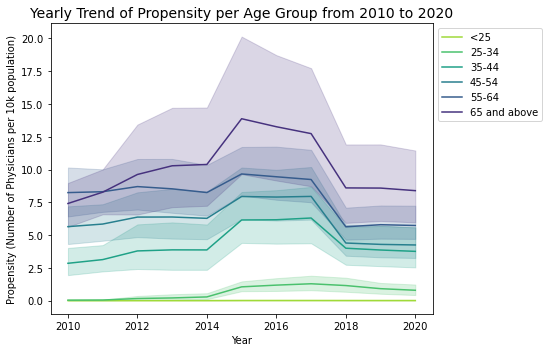

In [38]:
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.lineplot(data=df_merge_for_plot,
                  x='Year', y='value_revised_unit',
                  hue='Age Group', palette='viridis_r')
ax.set_title('Yearly Trend of Propensity per Age Group from 2010 to 2020',
             fontsize=14)

ax.set_ylabel('Propensity (Number of Physicians per 10k population)')
ax.legend(bbox_to_anchor=(1.3, 1));
plt.tight_layout()
# plt.savefig('figures/Propensity Trends per Age Group.png', dpi=300);

In [39]:
df_propensity_region = df_merge.copy()

In [40]:
df_propensity_region.columns

Index(['Region', 'Year', 'Pop_Age_<25', 'Pop_Age_25-34', 'Pop_Age_35-44',
       'Pop_Age_45-54', 'Pop_Age_55-64', 'Pop_Age_65 and above', 'Age_<25',
       'Age_25-34', 'Age_35-44', 'Age_45-54', 'Age_55-64', 'Age_65 and above',
       'propensity__<25', 'propensity__25-34', 'propensity__35-44',
       'propensity__45-54', 'propensity__55-64', 'propensity__65 and above'],
      dtype='object')

In [41]:
cols = ['Pop_Age_<25', 'Pop_Age_25-34', 'Pop_Age_35-44',
       'Pop_Age_45-54', 'Pop_Age_55-64', 'Pop_Age_65 and above']

df_propensity_region['Population'] = df_propensity_region[cols].sum(axis=1)

cols = ['Age_<25', 'Age_25-34', 'Age_35-44',
        'Age_45-54', 'Age_55-64', 'Age_65 and above']

df_propensity_region['Doctors'] = df_propensity_region[cols].sum(axis=1)

df_propensity_region

,Region,Year,Pop_Age_<25,Pop_Age_25-34,Pop_Age_35-44,Pop_Age_45-54,Pop_Age_55-64,Pop_Age_65 and above,Age_<25,Age_25-34,...,Age_55-64,Age_65 and above,propensity__<25,propensity__25-34,propensity__35-44,propensity__45-54,propensity__55-64,propensity__65 and above,Population,Doctors
0,BARMM,2010,2045100.0,458200.0,377400.0,227300.0,102600.0,53500.0,0.0,0.0,...,20.0,9.0,0.0,0.000000,0.000042,0.000066,0.000195,0.000168,3264100.0,60.0
1,BARMM,2011,2102978.4,473807.8,391183.2,236437.6,105985.6,55858.2,0.0,0.0,...,20.0,9.0,0.0,0.000000,0.000041,0.000059,0.000189,0.000161,3366250.8,59.0
2,BARMM,2012,2160856.8,489415.6,404966.4,245575.2,109371.2,58216.4,0.0,0.0,...,20.0,8.0,0.0,0.000000,0.000042,0.000053,0.000183,0.000137,3468401.6,58.0
3,BARMM,2013,2218735.2,505023.4,418749.6,254712.8,112756.8,60574.6,0.0,0.0,...,20.0,10.0,0.0,0.000000,0.000041,0.000051,0.000177,0.000165,3570552.4,60.0
4,BARMM,2014,2276613.6,520631.2,432532.8,263850.4,116142.4,62932.8,0.0,6.0,...,20.0,10.0,0.0,0.000012,0.000042,0.000049,0.000172,0.000159,3672703.2,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,XIII - Caraga,2016,1407026.0,382574.0,294475.0,243455.0,167009.0,132952.0,0.0,21.0,...,113.0,100.0,0.0,0.000055,0.000394,0.000464,0.000677,0.000752,2627491.0,463.0
183,XIII - Caraga,2017,1414948.0,394491.0,298810.0,244142.0,170563.0,137282.0,0.0,21.0,...,113.0,100.0,0.0,0.000053,0.000385,0.000459,0.000663,0.000728,2660236.0,461.0
184,XIII - Caraga,2018,1422138.0,406464.0,303070.0,244687.0,174093.0,141620.0,0.0,19.0,...,92.0,82.0,0.0,0.000047,0.000261,0.000360,0.000528,0.000579,2692072.0,360.0
185,XIII - Caraga,2019,1428619.0,418483.0,307255.0,245083.0,177596.0,145976.0,0.0,15.0,...,91.0,88.0,0.0,0.000036,0.000241,0.000375,0.000512,0.000603,2723012.0,360.0


In [42]:
df_propensity_region['Propensity'] = (df_propensity_region['Doctors']/df_propensity_region['Population'])*10000

In [43]:
df_propensity_region = df_propensity_region.groupby('Region')['Propensity'].mean().reset_index()

In [44]:
df_propensity_region.sort_values(by='Propensity', ascending=False)

,Region,Propensity
8,NCR,6.702234
1,CAR,4.396687
2,I - Ilocos,2.807185
4,III - C. Luzon,2.409683
3,II - Cagayan,2.332242
13,X - N. Mindanao,2.017582
11,VII - C. Visayas,1.985982
5,IVA - Calabarzon,1.878147
10,VI - W. Visayas,1.844942
14,XI - Davao,1.819500


In [45]:
regional_ordered = ['NCR', 'CAR', 'I - Ilocos', 'II - Cagayan',
                    'III - C. Luzon', 'IVA - Calabarzon', 'MIMAROPA',
                    'V - Bicol', 'VI - W. Visayas', 'VII - C. Visayas',
                    'VIII - E. Visayas', 'IX - Zamboanga', 'X - N. Mindanao',
                    'XI - Davao', 'XII - SOCCSKSARGEN',
                    'XIII - Caraga', 'BARMM']

df_propensity_region['Region_cat'] = pd.Categorical(
    df_propensity_region['Region'],
    regional_ordered)

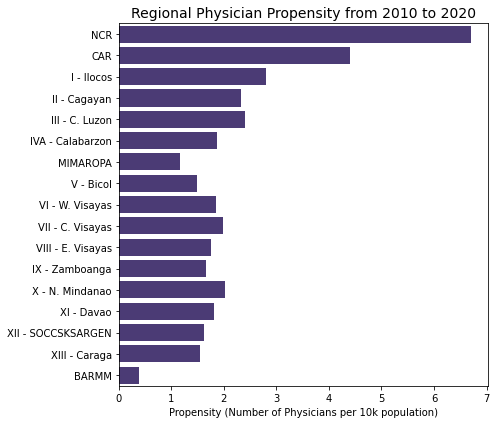

In [46]:
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.barplot(data=df_propensity_region, y='Region_cat', x='Propensity',
                 color=sns.color_palette("viridis_r")[-1]);
ax.set_title('Regional Physician Propensity from 2010 to 2020', fontsize=14)

ax.set_xlabel('Propensity (Number of Physicians per 10k population)')
ax.set_ylabel(None)
plt.tight_layout()
# plt.savefig('figures/Regional Physician Propensity.png', dpi=300);

In [47]:
df_merge_plot = df_merge.copy()

In [48]:
df_merge_plot.rename(columns = {'propensity__<25': 'Age < 25',
                                'propensity__25-34': 'Age 25-34',
                                'propensity__35-44': 'Age 35-44',
                                'propensity__45-54': 'Age 45-54',
                                'propensity__55-64': 'Age 55-64',
                                'propensity__65 and above': 'Age > 65'},
                    inplace=True)

In [49]:
cols = ['Age < 25', 'Age 25-34', 'Age 35-44',
        'Age 45-54', 'Age 55-64', 'Age > 65']
df_merge_plot = (df_merge_plot[cols])*10000
df_merge_plot = df_merge_plot.drop(columns=['Age < 25'], axis=1)

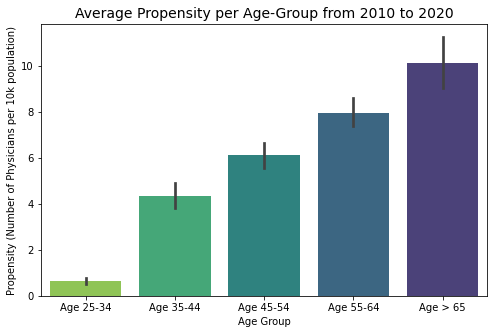

In [50]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.barplot(data=df_merge_plot, palette='viridis_r');
ax.set_title('Average Propensity per Age-Group from 2010 to 2020', fontsize=14)

# For alternative forecast only
# ax.set_title('Average Propensity per Age-Group (2010-2017)', fontsize=14)
ax.set_xlabel('Age Group')
ax.set_ylabel('Propensity (Number of Physicians per 10k population)');
# plt.savefig('figures/Average Propensity per Age-Group.png', dpi=300);

### Final propensity dataframe

In [51]:
df_propensity = df_merge.groupby('Region').agg({'propensity__<25':'mean',
                             'propensity__25-34':'mean',
                             'propensity__35-44':'mean',
                             'propensity__45-54':'mean',
                             'propensity__55-64':'mean',
                             'propensity__65 and above':'mean'}).reset_index()

In [52]:
df_propensity

,Region,propensity__<25,propensity__25-34,propensity__35-44,propensity__45-54,propensity__55-64,propensity__65 and above
0,BARMM,0.000000e+00,0.000033,0.000111,0.000121,0.000281,0.000146
1,CAR,0.000000e+00,0.000160,0.001140,0.001235,0.001363,0.001637
2,I - Ilocos,1.490868e-07,0.000037,0.000339,0.000776,0.001088,0.001165
3,II - Cagayan,0.000000e+00,0.000035,0.000367,0.000697,0.000897,0.000905
4,III - C. Luzon,3.913748e-07,0.000042,0.000423,0.000724,0.000749,0.001081
5,IVA - Calabarzon,3.041243e-07,0.000028,0.000327,0.000601,0.000671,0.000854
6,IX - Zamboanga,0.000000e+00,0.000075,0.000366,0.000465,0.000652,0.000723
7,MIMAROPA,0.000000e+00,0.000015,0.000158,0.000393,0.000631,0.000497
8,NCR,1.620518e-06,0.000260,0.001474,0.001501,0.001764,0.003434
9,V - Bicol,8.445621e-08,0.000035,0.000226,0.000463,0.000773,0.000593


In [53]:
df_propensity2 = pd.melt(df_propensity,
                        id_vars='Region',
                        value_name='propensity')

df_propensity2['Age_Group'] = ('Pop_Age' +
                              df_propensity2['variable']
                              .str.extract(r'propensity_(.*)'))

In [54]:
df_propensity2

,Region,variable,propensity,Age_Group
0,BARMM,propensity__<25,0.000000e+00,Pop_Age_<25
1,CAR,propensity__<25,0.000000e+00,Pop_Age_<25
2,I - Ilocos,propensity__<25,1.490868e-07,Pop_Age_<25
3,II - Cagayan,propensity__<25,0.000000e+00,Pop_Age_<25
4,III - C. Luzon,propensity__<25,3.913748e-07,Pop_Age_<25
...,...,...,...,...
97,VIII - E. Visayas,propensity__65 and above,1.146831e-03,Pop_Age_65 and above
98,X - N. Mindanao,propensity__65 and above,1.279053e-03,Pop_Age_65 and above
99,XI - Davao,propensity__65 and above,1.227602e-03,Pop_Age_65 and above
100,XII - SOCCSKSARGEN,propensity__65 and above,7.703472e-04,Pop_Age_65 and above


## Forecasting Supply

In [55]:
forecast1 = (pd.melt(data_pop,
                     id_vars=['Region', 'Year'],
                     var_name='Age_Group',
                     value_name='Population'))

forecast1['Pop_difference_from_last_year'] = forecast1.Population.diff()
forecast1

,Region,Year,Age_Group,Population,Pop_difference_from_last_year
0,BARMM,2010,Pop_Age_<25,2045100.0,NaN
1,BARMM,2011,Pop_Age_<25,2102978.4,57878.4
2,BARMM,2012,Pop_Age_<25,2160856.8,57878.4
3,BARMM,2013,Pop_Age_<25,2218735.2,57878.4
4,BARMM,2014,Pop_Age_<25,2276613.6,57878.4
...,...,...,...,...,...
2137,XIII - Caraga,2026,Pop_Age_65 and above,186495.2,14251.2
2138,XIII - Caraga,2027,Pop_Age_65 and above,200746.4,14251.2
2139,XIII - Caraga,2028,Pop_Age_65 and above,214997.6,14251.2
2140,XIII - Caraga,2029,Pop_Age_65 and above,229248.8,14251.2


In [56]:
forecast2 = pd.merge(forecast1, df_propensity2, how='left',
         left_on=['Region', 'Age_Group'],
         right_on=['Region', 'Age_Group'])

forecast2

,Region,Year,Age_Group,Population,Pop_difference_from_last_year,variable,propensity
0,BARMM,2010,Pop_Age_<25,2045100.0,NaN,propensity__<25,0.000000
1,BARMM,2011,Pop_Age_<25,2102978.4,57878.4,propensity__<25,0.000000
2,BARMM,2012,Pop_Age_<25,2160856.8,57878.4,propensity__<25,0.000000
3,BARMM,2013,Pop_Age_<25,2218735.2,57878.4,propensity__<25,0.000000
4,BARMM,2014,Pop_Age_<25,2276613.6,57878.4,propensity__<25,0.000000
...,...,...,...,...,...,...,...
2137,XIII - Caraga,2026,Pop_Age_65 and above,186495.2,14251.2,propensity__65 and above,0.000679
2138,XIII - Caraga,2027,Pop_Age_65 and above,200746.4,14251.2,propensity__65 and above,0.000679
2139,XIII - Caraga,2028,Pop_Age_65 and above,214997.6,14251.2,propensity__65 and above,0.000679
2140,XIII - Caraga,2029,Pop_Age_65 and above,229248.8,14251.2,propensity__65 and above,0.000679


In [57]:
forecast2['Pop_Diff x Propensity'] = (
    forecast2['Pop_difference_from_last_year'] *
    forecast2['propensity'])

forecast2

,Region,Year,Age_Group,Population,Pop_difference_from_last_year,variable,propensity,Pop_Diff x Propensity
0,BARMM,2010,Pop_Age_<25,2045100.0,NaN,propensity__<25,0.000000,NaN
1,BARMM,2011,Pop_Age_<25,2102978.4,57878.4,propensity__<25,0.000000,0.000000
2,BARMM,2012,Pop_Age_<25,2160856.8,57878.4,propensity__<25,0.000000,0.000000
3,BARMM,2013,Pop_Age_<25,2218735.2,57878.4,propensity__<25,0.000000,0.000000
4,BARMM,2014,Pop_Age_<25,2276613.6,57878.4,propensity__<25,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2137,XIII - Caraga,2026,Pop_Age_65 and above,186495.2,14251.2,propensity__65 and above,0.000679,9.673708
2138,XIII - Caraga,2027,Pop_Age_65 and above,200746.4,14251.2,propensity__65 and above,0.000679,9.673708
2139,XIII - Caraga,2028,Pop_Age_65 and above,214997.6,14251.2,propensity__65 and above,0.000679,9.673708
2140,XIII - Caraga,2029,Pop_Age_65 and above,229248.8,14251.2,propensity__65 and above,0.000679,9.673708


In [58]:
data_doctor.head(5)

,Region,Year,Age_<25,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65 and above,Age_No info
0,BARMM,2010,0.0,0.0,16.0,15.0,20.0,9.0,1.0
1,BARMM,2011,0.0,0.0,16.0,14.0,20.0,9.0,1.0
2,BARMM,2012,0.0,0.0,17.0,13.0,20.0,8.0,1.0
3,BARMM,2013,0.0,0.0,17.0,13.0,20.0,10.0,1.0
4,BARMM,2014,0.0,6.0,18.0,13.0,20.0,10.0,1.0


In [59]:
age_cols = ['Age_<25', 'Age_25-34', 'Age_35-44', 'Age_45-54',
       'Age_55-64', 'Age_65 and above', 'Age_No info']

data_doctor['Actual'] = data_doctor[age_cols].sum(axis=1)
data_doctor

,Region,Year,Age_<25,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65 and above,Age_No info,Actual
0,BARMM,2010,0.0,0.0,16.0,15.0,20.0,9.0,1.0,61.0
1,BARMM,2011,0.0,0.0,16.0,14.0,20.0,9.0,1.0,60.0
2,BARMM,2012,0.0,0.0,17.0,13.0,20.0,8.0,1.0,59.0
3,BARMM,2013,0.0,0.0,17.0,13.0,20.0,10.0,1.0,61.0
4,BARMM,2014,0.0,6.0,18.0,13.0,20.0,10.0,1.0,68.0
...,...,...,...,...,...,...,...,...,...,...
182,XIII - Caraga,2016,0.0,21.0,116.0,113.0,113.0,100.0,0.0,463.0
183,XIII - Caraga,2017,0.0,21.0,115.0,112.0,113.0,100.0,0.0,461.0
184,XIII - Caraga,2018,0.0,19.0,79.0,88.0,92.0,82.0,0.0,360.0
185,XIII - Caraga,2019,0.0,15.0,74.0,92.0,91.0,88.0,0.0,360.0


In [60]:
# Create new rows for forecast years
for region in data_doctor.Region.unique():
    for year in range(2021, 2031):
        new_row = {'Region':region, 'Year':year}
        data_doctor = data_doctor.append(new_row, ignore_index=True)

In [61]:
def get_forecast(Region, Forecast_year, Base_year, df_1, df_2):
    """
    Get raw number forecast of physicians using
    the propensity-based approach.
    """
    if Forecast_year <= Base_year:
        final_forecast = None
    else:
        term1 = (df_1.loc[(df_1['Region']==Region) &
                                  (df_1['Year']==Base_year),
                                  'Actual'].values[0])

        df_2 = (df_2.loc[(df_2['Region']==Region) &
                         (df_2['Year']>Base_year) &
                         (df_2['Year']<=Forecast_year)])

        term2 = df_2['Pop_Diff x Propensity'].sum()
        final_forecast = int(term1 + term2)
    return final_forecast

In [62]:
def get_forecast_age(Region, Forecast_year, Base_year, df_1, df_2, age_group):
    """
    Get raw number forecast of physicians per age-group using
    the propensity-based approach.
    """
    if Forecast_year <= Base_year:
        final_forecast = None
    else:
        term1 = (df_1.loc[(df_1['Region']==Region) &
                                  (df_1['Year']==Base_year),
                                  age_group].values[0])

        df_2 = (df_2.loc[(df_2['Region']==Region) &
                         (df_2['Year']>Base_year) &
                         (df_2['Year']<=Forecast_year) &
                         (df_2['Age_Group']=='Pop_'+age_group)])

        term2 = df_2['Pop_Diff x Propensity'].sum()
        final_forecast = int(term1 + term2)
    return final_forecast

In [63]:
# Get age-specific forecasts
age_list = ['Age_<25', 'Age_25-34', 'Age_35-44', 'Age_45-54',
            'Age_55-64', 'Age_65 and above']
for age_group in age_list:
    data_doctor[age_group+'_forecast'] = (data_doctor
                                          .apply(lambda x:get_forecast_age(
                                          x["Region"],
                                          x["Year"],
                                          2020,
                                          data_doctor,
                                          forecast2,
                                          age_group), axis=1))

data_doctor

,Region,Year,Age_<25,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65 and above,Age_No info,Actual,Age_<25_forecast,Age_25-34_forecast,Age_35-44_forecast,Age_45-54_forecast,Age_55-64_forecast,Age_65 and above_forecast
0,BARMM,2010,0.0,0.0,16.0,15.0,20.0,9.0,1.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN
1,BARMM,2011,0.0,0.0,16.0,14.0,20.0,9.0,1.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN
2,BARMM,2012,0.0,0.0,17.0,13.0,20.0,8.0,1.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN
3,BARMM,2013,0.0,0.0,17.0,13.0,20.0,10.0,1.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN
4,BARMM,2014,0.0,6.0,18.0,13.0,20.0,10.0,1.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,XIII - Caraga,2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.0,86.0,98.0,109.0,115.0
353,XIII - Caraga,2027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.0,95.0,103.0,115.0,125.0
354,XIII - Caraga,2028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.0,104.0,109.0,122.0,134.0
355,XIII - Caraga,2029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,17.0,114.0,114.0,128.0,144.0


In [64]:
# Get raw count forecasts
data_doctor["Supply_Forecast"] = (data_doctor
                                   .apply(lambda x:get_forecast(
                                       x["Region"],
                                       x["Year"],
                                       2020,  # change depends on forecast
                                       data_doctor,
                                       forecast2), axis=1))

data_doctor

,Region,Year,Age_<25,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65 and above,Age_No info,Actual,Age_<25_forecast,Age_25-34_forecast,Age_35-44_forecast,Age_45-54_forecast,Age_55-64_forecast,Age_65 and above_forecast,Supply_Forecast
0,BARMM,2010,0.0,0.0,16.0,15.0,20.0,9.0,1.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BARMM,2011,0.0,0.0,16.0,14.0,20.0,9.0,1.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BARMM,2012,0.0,0.0,17.0,13.0,20.0,8.0,1.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BARMM,2013,0.0,0.0,17.0,13.0,20.0,10.0,1.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BARMM,2014,0.0,6.0,18.0,13.0,20.0,10.0,1.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,XIII - Caraga,2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.0,86.0,98.0,109.0,115.0,424.0
353,XIII - Caraga,2027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.0,95.0,103.0,115.0,125.0,456.0
354,XIII - Caraga,2028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.0,104.0,109.0,122.0,134.0,487.0
355,XIII - Caraga,2029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,17.0,114.0,114.0,128.0,144.0,518.0


In [65]:
# Create column with combined historical records and forecasts
data_doctor['Combined_Actual_and_Forecast'] = (data_doctor['Supply_Forecast']
                                               .fillna(data_doctor['Actual']))

### Plots for Age-Distribution of Supply Forecasts

In [66]:
doctor_age = data_doctor.copy()
doctor_age

,Region,Year,Age_<25,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65 and above,Age_No info,Actual,Age_<25_forecast,Age_25-34_forecast,Age_35-44_forecast,Age_45-54_forecast,Age_55-64_forecast,Age_65 and above_forecast,Supply_Forecast,Combined_Actual_and_Forecast
0,BARMM,2010,0.0,0.0,16.0,15.0,20.0,9.0,1.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0
1,BARMM,2011,0.0,0.0,16.0,14.0,20.0,9.0,1.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0
2,BARMM,2012,0.0,0.0,17.0,13.0,20.0,8.0,1.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0
3,BARMM,2013,0.0,0.0,17.0,13.0,20.0,10.0,1.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0
4,BARMM,2014,0.0,6.0,18.0,13.0,20.0,10.0,1.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,XIII - Caraga,2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.0,86.0,98.0,109.0,115.0,424.0,424.0
353,XIII - Caraga,2027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.0,95.0,103.0,115.0,125.0,456.0,456.0
354,XIII - Caraga,2028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.0,104.0,109.0,122.0,134.0,487.0,487.0
355,XIII - Caraga,2029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,17.0,114.0,114.0,128.0,144.0,518.0,518.0


In [67]:
doctor_age.columns

Index(['Region', 'Year', 'Age_<25', 'Age_25-34', 'Age_35-44', 'Age_45-54',
       'Age_55-64', 'Age_65 and above', 'Age_No info', 'Actual',
       'Age_<25_forecast', 'Age_25-34_forecast', 'Age_35-44_forecast',
       'Age_45-54_forecast', 'Age_55-64_forecast', 'Age_65 and above_forecast',
       'Supply_Forecast', 'Combined_Actual_and_Forecast'],
      dtype='object')

In [68]:
age_cols = ['Age_<25', 'Age_25-34',
            'Age_35-44','Age_45-54',
            'Age_55-64', 'Age_65 and above']

doctor_age['Average Age actual'] = (doctor_age['Age_<25']*25 +
                                    doctor_age['Age_25-34']*30 +
                                    doctor_age['Age_35-44']*40 +
                                    doctor_age['Age_45-54']*50 +
                                    doctor_age['Age_55-64']*60 +
                                    doctor_age['Age_65 and above']*65)/doctor_age[age_cols].sum(axis=1)

In [69]:
age_cols = ['Age_<25_forecast', 'Age_25-34_forecast',
            'Age_35-44_forecast','Age_45-54_forecast',
            'Age_55-64_forecast', 'Age_65 and above_forecast']

doctor_age['Average Age forecast'] = (doctor_age['Age_<25_forecast']*25 +
                                    doctor_age['Age_25-34_forecast']*30 +
                                    doctor_age['Age_35-44_forecast']*40 +
                                    doctor_age['Age_45-54_forecast']*50 +
                                    doctor_age['Age_55-64_forecast']*60 +
                                    doctor_age['Age_65 and above_forecast']*65)/doctor_age[age_cols].sum(axis=1)

In [70]:
doctor_age

,Region,Year,Age_<25,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65 and above,Age_No info,Actual,Age_<25_forecast,Age_25-34_forecast,Age_35-44_forecast,Age_45-54_forecast,Age_55-64_forecast,Age_65 and above_forecast,Supply_Forecast,Combined_Actual_and_Forecast,Average Age actual,Average Age forecast
0,BARMM,2010,0.0,0.0,16.0,15.0,20.0,9.0,1.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,52.916667,NaN
1,BARMM,2011,0.0,0.0,16.0,14.0,20.0,9.0,1.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,52.966102,NaN
2,BARMM,2012,0.0,0.0,17.0,13.0,20.0,8.0,1.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,52.586207,NaN
3,BARMM,2013,0.0,0.0,17.0,13.0,20.0,10.0,1.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,53.000000,NaN
4,BARMM,2014,0.0,6.0,18.0,13.0,20.0,10.0,1.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,50.746269,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,XIII - Caraga,2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.0,86.0,98.0,109.0,115.0,424.0,424.0,NaN,53.912530
353,XIII - Caraga,2027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.0,95.0,103.0,115.0,125.0,456.0,456.0,NaN,53.918322
354,XIII - Caraga,2028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.0,104.0,109.0,122.0,134.0,487.0,487.0,NaN,53.855670
355,XIII - Caraga,2029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,17.0,114.0,114.0,128.0,144.0,518.0,518.0,NaN,53.791103


In [71]:
labels = ["NCR", "CAR", "I - Ilocos", "II - Cagayan",
          "III - C. Luzon", "IVA - Calabarzon",
          "MIMAROPA", "V - Bicol", "VI - W. Visayas",
          "VII - C. Visayas", "VIII - E. Visayas", 
          "IX - Zamboanga",
          "X - N. Mindanao", "XI - Davao", "XII - SOCCSKSARGEN",
          "XIII - Caraga", "BARMM"]

In [72]:
# BASELINE
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
          'tab:purple', 'tab:brown',
          'tab:pink', 'indigo', 'tab:olive',
          'tab:cyan', 'darkmagenta',
          'maroon',
          'lime', 'darkolivegreen', 'cadetblue',
          'darkgoldenrod', 'fuchsia']

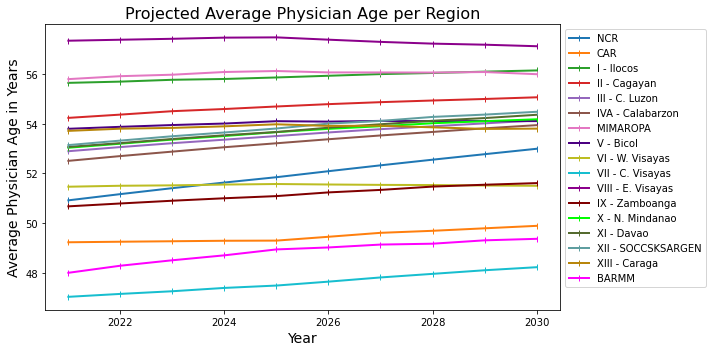

In [73]:
plt.figure(figsize=(10,5))

for i,j in enumerate(labels):
    df_y = doctor_age[doctor_age['Region'] == j]
    
#     if j in ["VIII - E. Visayas", "I - Ilocos", "MIMAROPA",
#              "VII - C. Visayas", 'CAR', 'BARMM']:
    plt.plot(df_y['Year'], df_y['Average Age forecast'], '|-',
                 label=j, lw=2, color=colors[i])
#     else:
#         plt.plot(df_y['Year'], df_y['Average Age forecast'], '|-',
#                  label=j, lw=2, color='darkgrey')

plt.legend(bbox_to_anchor=(1,1))
    
plt.title('Projected Average Physician Age per Region',
          fontsize=16)

plt.ylabel('Average Physician Age in Years', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.tight_layout()
# plt.savefig('figures/Age Average Regional Forecast_ALL.png', dpi=300);

In [74]:
doctor_age.loc[doctor_age['Year']==2030, ['Region', 'Average Age forecast']].sort_values(by='Average Age forecast', ascending=False)

,Region,Average Age forecast
316,VIII - E. Visayas,57.114402
216,I - Ilocos,56.141553
266,MIMAROPA,55.990888
226,II - Cagayan,55.061798
346,XII - SOCCSKSARGEN,54.479614
336,XI - Davao,54.359444
326,X - N. Mindanao,54.177632
236,III - C. Luzon,54.130905
286,V - Bicol,54.105691
246,IVA - Calabarzon,53.942025


In [75]:
# doctor_age.pivot(index=['Region'], columns='Year', values=['Average Age actual', 'Average Age forecast']).to_csv('Forecasted Age.csv')

In [76]:
data_doctor_2020 = data_doctor.loc[data_doctor['Year']==2020]
data_doctor_2025 = data_doctor.loc[data_doctor['Year']==2025]
data_doctor_2030 = data_doctor.loc[data_doctor['Year']==2030]

In [77]:
# Uncomment for baseline forecast
data_doctor_2020 = data_doctor_2020[['Region', 'Age_<25', 'Age_25-34',
                                     'Age_35-44', 'Age_45-54', 'Age_55-64',
                                     'Age_65 and above']]

#keep
data_doctor_2025 = data_doctor_2025[['Region', 'Age_<25_forecast',
                                     'Age_25-34_forecast',
                                     'Age_35-44_forecast',
                                     'Age_45-54_forecast',
                                     'Age_55-64_forecast',
                                     'Age_65 and above_forecast']]

data_doctor_2030 = data_doctor_2030[['Region', 'Age_<25_forecast',
                                     'Age_25-34_forecast',
                                     'Age_35-44_forecast',
                                     'Age_45-54_forecast',
                                     'Age_55-64_forecast',
                                     'Age_65 and above_forecast']]

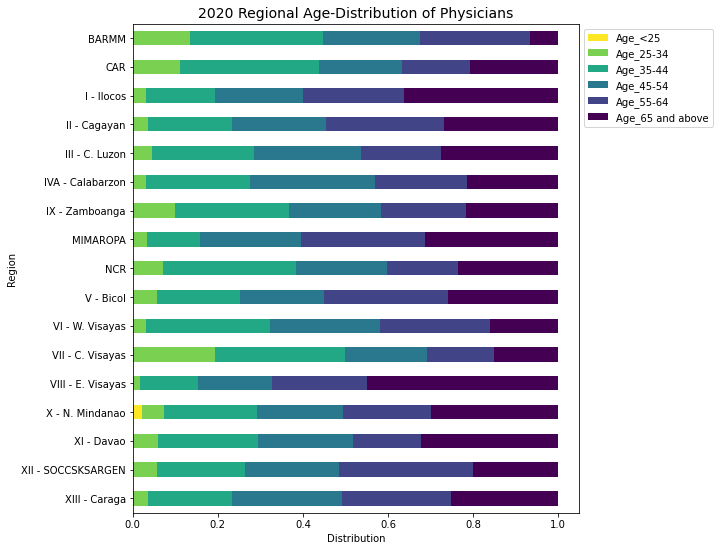

In [78]:
data_doctor_2020.iloc[:, 1:] = data_doctor_2020.iloc[:, 1:].div(data_doctor_2020.iloc[:, 1:].sum(axis=1), axis=0)
data_doctor_2020.set_index('Region', inplace=True)

ax = data_doctor_2020.plot.barh(stacked=True, figsize=(8,9), cmap='viridis_r')
ax.legend(bbox_to_anchor=(1, 1));
ax.set_title('2020 Regional Age-Distribution of Physicians', fontsize=14)
ax.set_xlabel('Distribution')
ax.set_ylabel('Region')
ax.invert_yaxis();
# plt.tight_layout();
# plt.savefig('2020 Regional Age-Distribution of Physicians.png', dpi=300, bbox_inches='tight');

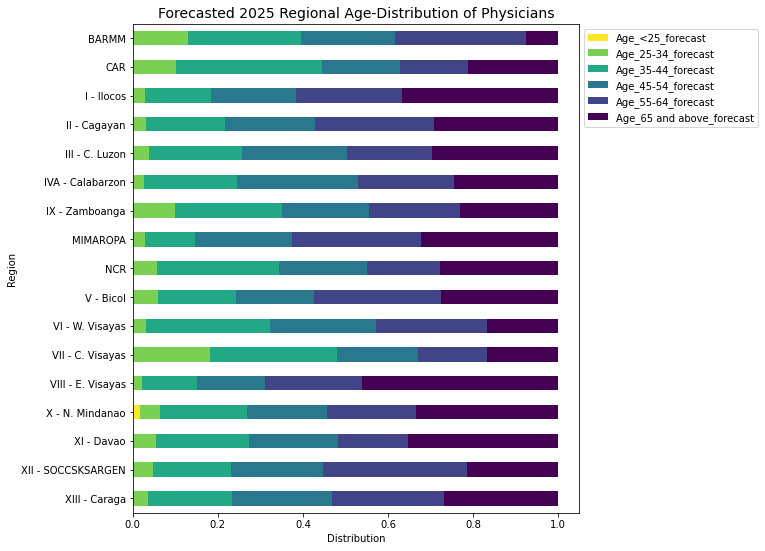

In [79]:
data_doctor_2025.iloc[:, 1:] = data_doctor_2025.iloc[:, 1:].div(data_doctor_2025.iloc[:, 1:].sum(axis=1), axis=0)
data_doctor_2025.set_index('Region', inplace=True)

ax = data_doctor_2025.plot.barh(stacked=True, figsize=(8,9), cmap='viridis_r')
ax.legend(bbox_to_anchor=(1, 1));
ax.set_title('Forecasted 2025 Regional Age-Distribution of Physicians', fontsize=14)
ax.set_xlabel('Distribution')
ax.set_ylabel('Region')
ax.invert_yaxis();
# plt.savefig('Forecasted 2025 Regional Age-Distribution of Physicians.png', dpi=300, bbox_inches='tight');

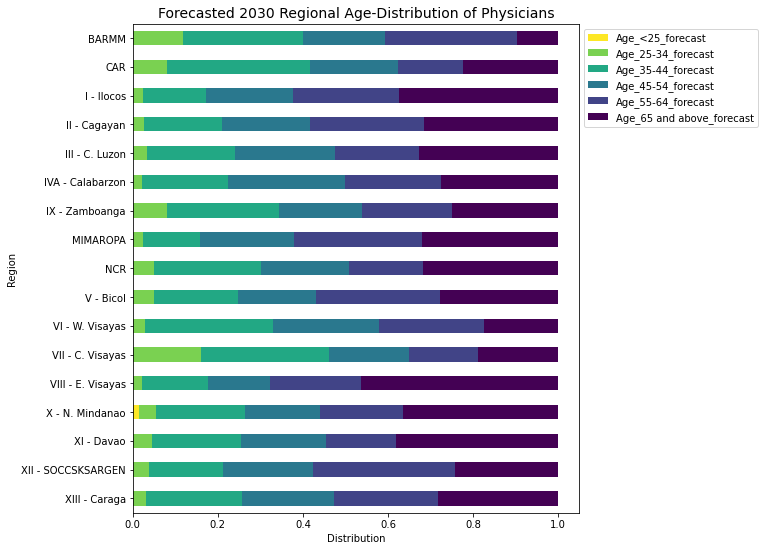

In [80]:
data_doctor_2030.iloc[:, 1:] = data_doctor_2030.iloc[:, 1:].div(data_doctor_2030.iloc[:, 1:].sum(axis=1), axis=0)
data_doctor_2030.set_index('Region', inplace=True)

ax = data_doctor_2030.plot.barh(stacked=True, figsize=(8,9), cmap='viridis_r')
ax.legend(bbox_to_anchor=(1, 1));
ax.set_title('Forecasted 2030 Regional Age-Distribution of Physicians', fontsize=14)
ax.set_xlabel('Distribution')
ax.set_ylabel('Region')
ax.invert_yaxis();
# plt.savefig('Forecasted 2030 Regional Age-Distribution of Physicians.png', dpi=300, bbox_inches='tight');

### Error Metric

In [81]:
# data_doctor_metrics_2019 = data_doctor.loc[(data_doctor.Year==2019)]
# data_doctor_metrics_2020 = data_doctor.loc[(data_doctor.Year==2020)]

In [82]:
# data_doctor_metrics_2019.rename(columns={'Supply_Forecast': 'Forecast'}, inplace=True)
# data_doctor_metrics_2020.rename(columns={'Supply_Forecast': 'Forecast'}, inplace=True)

In [83]:
# def df_to_np(arr):
#     """Ensure input is a numpy array."""
#     if type(arr) != np.ndarray:
#         return arr.to_numpy()
#     else:
#         return arr

# def MAPE(y_actual, y_pred):
#     arr_act = y_actual
#     arr_pred = y_pred
#     return np.mean(np.abs(1 - arr_pred / arr_act))

In [84]:
# y_actual = np.array([data_doctor_metrics_2019['Actual'].sum(),
#                     data_doctor_metrics_2020['Actual'].sum()])

# y_pred = np.array([data_doctor_metrics_2019['Forecast'].sum(),
#                     data_doctor_metrics_2020['Forecast'].sum()])

# MAPE(y_actual, y_pred)

In [85]:
# mape = mean_absolute_percentage_error(y_actual, y_pred)
# mape

### Plots for Regional Forecasts

In [86]:
data_doctor2 = pd.merge(regional_pop, data_doctor, how='right',
         left_on=['Year', 'Region'],
         right_on=['Year', 'Region'])

In [87]:
data_doctor2['Final_Supply_per_10k'] = (
    (data_doctor2['Combined_Actual_and_Forecast'] /
     data_doctor2['Population'])*10000)

In [88]:
data_doctor2 = data_doctor2[['Year', 'Region',
                             'Population', 'Actual',
                             'Supply_Forecast',
                             'Combined_Actual_and_Forecast',
                             'Final_Supply_per_10k']]
data_doctor2

,Year,Region,Population,Actual,Supply_Forecast,Combined_Actual_and_Forecast,Final_Supply_per_10k
0,2010,BARMM,3264100.0,61.0,NaN,61.0,0.186882
1,2011,BARMM,3366250.8,60.0,NaN,60.0,0.178240
2,2012,BARMM,3468401.6,59.0,NaN,59.0,0.170107
3,2013,BARMM,3570552.4,61.0,NaN,61.0,0.170842
4,2014,BARMM,3672703.2,68.0,NaN,68.0,0.185150
...,...,...,...,...,...,...,...
352,2026,XIII - Caraga,3031391.2,NaN,424.0,424.0,1.398698
353,2027,XIII - Caraga,3173093.4,NaN,456.0,456.0,1.437083
354,2028,XIII - Caraga,3314795.6,NaN,487.0,487.0,1.469171
355,2029,XIII - Caraga,3456497.8,NaN,518.0,518.0,1.498627


In [89]:
# data_doctor2.to_csv('../data/processed/'
#                     '2010-30_regional_supply_forecasts_final.csv',
#                     index=False)

In [90]:
data_doctor3 = data_doctor2.loc[data_doctor2['Year']>=2010]

In [91]:
data_doctor3['Year'] = pd.to_datetime(data_doctor3['Year'], format='%Y')

In [92]:
# BASELINE
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
          'tab:purple', 'tab:brown',
          'tab:pink', 'indigo', 'tab:olive',
          'tab:cyan', 'darkmagenta',
          'maroon', 'lime', 'darkolivegreen', 'cadetblue',
          'darkgoldenrod', 'fuchsia']

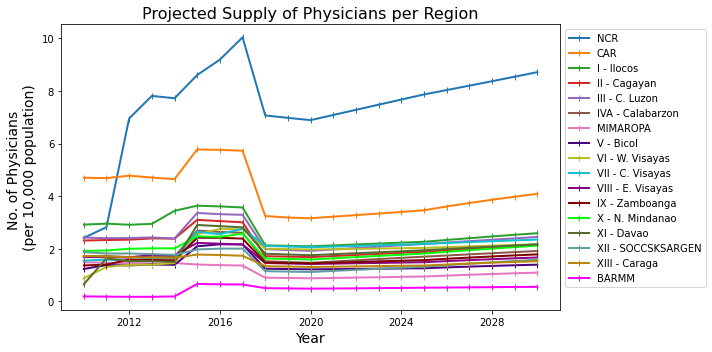

In [93]:
plt.figure(figsize=(10, 5))
for i,j in enumerate(labels):
    df_y = data_doctor3[data_doctor3['Region'] == j]
    
    if j in [""]:
        plt.plot(df_y['Year'], df_y['Final_Supply_per_10k'], '|-',
                 label=j, lw=2, color='darkgrey')
    else:
        plt.plot(df_y['Year'], df_y['Final_Supply_per_10k'], '|-',
                 label=j, lw=2, color=colors[i])
        
plt.legend(bbox_to_anchor=(1,1))
    
plt.title('Projected Supply of Physicians per Region',
          fontsize=16)

plt.ylabel('No. of Physicians \n(per 10,000 population)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.tight_layout()
# plt.savefig('figures/Supply of Physicians per Region_BARMIMA.png', dpi=300);

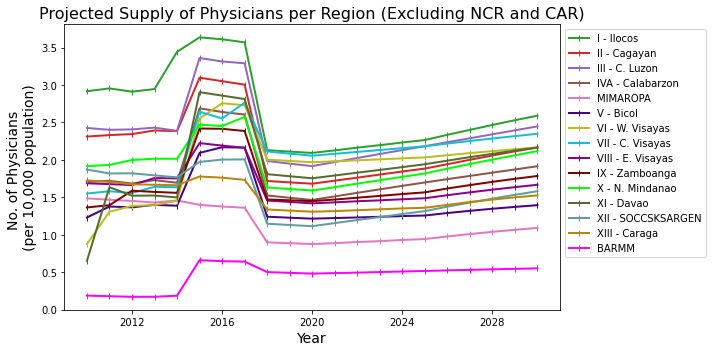

In [94]:
plt.figure(figsize=(10, 5))
   
for i,j in enumerate(labels[2:]):
    df_y = data_doctor3[data_doctor3['Region'] == j]
    
    if j in [""]:
        plt.plot(df_y['Year'], df_y['Final_Supply_per_10k'], '|-',
                 label=j, lw=2, color='darkgrey')
    else:
        plt.plot(df_y['Year'], df_y['Final_Supply_per_10k'], '|-',
                 label=j, lw=2, color=colors[i+2])
plt.legend(bbox_to_anchor=(1,1))
    
# plt.xticks(np.arange(2020,2031,2))
plt.title('Projected Supply of Physicians per Region (Excluding NCR and CAR)',
          fontsize=16)

plt.ylabel('No. of Physicians \n(per 10,000 population)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.tight_layout()
# plt.savefig('figures/Projected Supply of Physicians per Region (Excluding NCR and CAR)_2.png', dpi=300);

### Plots for National Forecasts

In [95]:
path_forecast_1 = '../data/processed/2010-30_regional_supply_forecasts_final.csv'
path_forecast_bl = '../data/processed/2021-30_baseline_supply_forecasts.csv'
path_scenario = '../data/processed/Scenarios for Recos.xlsx'

df_forecast_1 = pd.read_csv(path_forecast_1)
df_forecast_bl = pd.read_csv(path_forecast_bl)
df_scenario = pd.read_excel(path_scenario)

In [96]:
df_forecast_1 = (df_forecast_1[['Year', 'Region', 'Population',
                                'Actual', 'Supply_Forecast',
                                'Combined_Actual_and_Forecast']])

df_forecast_bl = df_forecast_bl[['Year', 'Region',
                                 'Average Historical Proportions',
                                 'Proportions of Historical Averages']]

In [97]:
# Rename region names to be consistent with other datasets
df_forecast_bl['Region'] = df_forecast_bl['Region'].map(region_new_name_map)
df_forecast_bl.Region.unique()

array(['BARMM', 'CAR', 'MIMAROPA', 'NCR', 'I - Ilocos', 'II - Cagayan',
       'III - C. Luzon', 'IVA - Calabarzon', 'IX - Zamboanga',
       'V - Bicol', 'VI - W. Visayas', 'VII - C. Visayas',
       'VIII - E. Visayas', 'X - N. Mindanao', 'XI - Davao',
       'XII - SOCCSKSARGEN', 'XIII - Caraga'], dtype=object)

In [98]:
# Aggregate regional forecasts to national forecasts
df_forecast_1 = df_forecast_1.groupby('Year').sum().reset_index()
df_forecast_bl = df_forecast_bl.groupby('Year').sum().reset_index()
df_scenario = df_scenario.groupby('Year').sum().reset_index()

In [99]:
df_merge = pd.merge(df_forecast_1, df_forecast_bl, how='left',
                    left_on=['Year'], right_on=['Year'])
df_merge.head(10)

,Year,Population,Actual,Supply_Forecast,Combined_Actual_and_Forecast,Average Historical Proportions,Proportions of Historical Averages
0,2010,93135100.0,16779.0,0.0,16779.0,NaN,NaN
1,2011,94674754.2,18395.0,0.0,18395.0,NaN,NaN
2,2012,96214408.4,23776.0,0.0,23776.0,NaN,NaN
3,2013,97754062.6,25437.0,0.0,25437.0,NaN,NaN
4,2014,99293716.8,25865.0,0.0,25865.0,NaN,NaN
5,2015,100833371.0,34135.0,0.0,34135.0,NaN,NaN
6,2016,102530196.0,35391.0,0.0,35391.0,NaN,NaN
7,2017,104169230.0,37082.0,0.0,37082.0,NaN,NaN
8,2018,105755180.0,24791.0,0.0,24791.0,NaN,NaN
9,2019,107288150.0,24786.0,0.0,24786.0,NaN,NaN


In [100]:
df_scenario = df_scenario[['Year', 'Population', 'Actual',
                           'Propensity', 'Increase Schools',
                           'Accelerated Degrees', 'Increase PLE score',
                           'Maximum capacity']]

In [101]:
df_merge = pd.merge(df_merge, df_scenario, how='left',
                    left_on=['Year'], right_on=['Year'])
df_merge.head(15)

,Year,Population_x,Actual_x,Supply_Forecast,Combined_Actual_and_Forecast,Average Historical Proportions,Proportions of Historical Averages,Population_y,Actual_y,Propensity,Increase Schools,Accelerated Degrees,Increase PLE score,Maximum capacity
0,2010,93135100.0,16779.0,0.0,16779.0,NaN,NaN,92335113.0,16779.0,0.0,0.0,0.0,0.0,0.0
1,2011,94674754.2,18395.0,0.0,18395.0,NaN,NaN,94034764.6,18395.0,0.0,0.0,0.0,0.0,0.0
2,2012,96214408.4,23776.0,0.0,23776.0,NaN,NaN,95734416.2,23776.0,0.0,0.0,0.0,0.0,0.0
3,2013,97754062.6,25437.0,0.0,25437.0,NaN,NaN,97434067.8,25437.0,0.0,0.0,0.0,0.0,0.0
4,2014,99293716.8,25865.0,0.0,25865.0,NaN,NaN,99133719.4,25865.0,0.0,0.0,0.0,0.0,0.0
5,2015,100833371.0,34135.0,0.0,34135.0,NaN,NaN,100833371.0,34135.0,0.0,0.0,0.0,0.0,0.0
6,2016,102530196.0,35391.0,0.0,35391.0,NaN,NaN,102530196.0,35391.0,0.0,0.0,0.0,0.0,0.0
7,2017,104169230.0,37082.0,0.0,37082.0,NaN,NaN,104169230.0,37082.0,0.0,0.0,0.0,0.0,0.0
8,2018,105755180.0,24791.0,0.0,24791.0,NaN,NaN,105755180.0,24791.0,0.0,0.0,0.0,0.0,0.0
9,2019,107288150.0,24786.0,0.0,24786.0,NaN,NaN,107288150.0,24786.0,0.0,0.0,0.0,0.0,0.0


In [102]:
df_merge.columns

Index(['Year', 'Population_x', 'Actual_x', 'Supply_Forecast',
       'Combined_Actual_and_Forecast', 'Average Historical Proportions',
       'Proportions of Historical Averages', 'Population_y', 'Actual_y',
       'Propensity', 'Increase Schools', 'Accelerated Degrees',
       'Increase PLE score', 'Maximum capacity'],
      dtype='object')

In [103]:
cols = ['Actual_x', 'Supply_Forecast', 'Combined_Actual_and_Forecast',
       'Average Historical Proportions', 'Proportions of Historical Averages',
       'Population_y', 'Actual_y', 'Propensity', 'Increase Schools',
       'Accelerated Degrees', 'Increase PLE score', 'Maximum capacity']

df_merge[cols] = df_merge[cols].replace({0:np.nan})

In [104]:
df_merge.columns

Index(['Year', 'Population_x', 'Actual_x', 'Supply_Forecast',
       'Combined_Actual_and_Forecast', 'Average Historical Proportions',
       'Proportions of Historical Averages', 'Population_y', 'Actual_y',
       'Propensity', 'Increase Schools', 'Accelerated Degrees',
       'Increase PLE score', 'Maximum capacity'],
      dtype='object')

In [105]:
df_national = df_merge.copy()
df_national = df_national[['Year', 'Population_x', 'Actual_x',
                           'Supply_Forecast', 'Combined_Actual_and_Forecast']]
df_national.rename(columns={'Population_x':'Population',
                            'Actual_x': 'Actual'}, inplace=True)

df_national['Final_Supply_per_10k'] = (
    (df_national['Combined_Actual_and_Forecast'] /
     df_national['Population'])*10000)
# df_national.to_csv('../data/processed/'
#                    '2010-30_national_supply_forecasts_final.csv',
#                    index=False)

In [106]:
# This is only for plot prettification
df_merge.loc[df_merge['Year']==2020, 'Supply_Forecast'] = 24786
df_merge.loc[df_merge['Year']==2020, 'Average Historical Proportions'] = 24786
df_merge.loc[df_merge['Year']==2020, 'Proportions of Historical Averages'] = 24786
df_merge.loc[df_merge['Year']==2020, 'Increase Schools'] = 24786
df_merge.loc[df_merge['Year']==2020, 'Accelerated Degrees'] = 24786
df_merge.loc[df_merge['Year']==2020, 'Increase PLE score'] = 24786
df_merge.loc[df_merge['Year']==2020, 'Maximum capacity'] = 24786

In [107]:
df_merge = df_merge.loc[df_merge['Year']>=2018]

df_merge['Year'] = pd.to_datetime(df_merge['Year'], format='%Y')

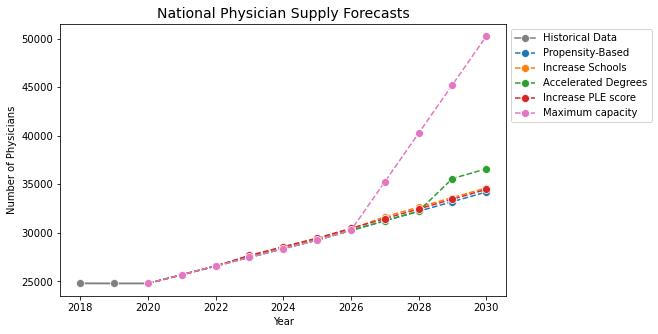

In [108]:
# FOR BASELINE

fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.lineplot(data=df_merge,
                  x='Year', y="Actual_x", label=None, marker="o",
                  markersize=8, color='grey')
ax = sns.lineplot(data=df_merge,
                  x='Year', y="Actual_y", label="Historical Data",
                  marker="o", markersize=8, color='grey')
ax = sns.lineplot(data=df_merge,
                  x='Year', y='Supply_Forecast',
                  label='Propensity-Based',
                  marker='o', markersize=8,
                  linestyle='--',
                  color=sns.color_palette("tab10")[0])
ax = sns.lineplot(data=df_merge,
                  x='Year', y='Increase Schools',
                  label='Increase Schools',
                  marker='o', markersize=8,
                  linestyle='--',
                  color=sns.color_palette("tab10")[1])
ax = sns.lineplot(data=df_merge,
                  x='Year', y='Accelerated Degrees',
                  label='Accelerated Degrees',
                  marker='o', markersize=8,
                  linestyle='--',
                  color=sns.color_palette("tab10")[2])
ax = sns.lineplot(data=df_merge,
                  x='Year', y='Increase PLE score',
                  label='Increase PLE score',
                  marker='o', markersize=8,
                  linestyle='--',
                  color=sns.color_palette("tab10")[3])
ax = sns.lineplot(data=df_merge,
                  x='Year', y='Maximum capacity',
                  label='Maximum capacity',
                  marker='o', markersize=8,
                  linestyle='--',
                  color=sns.color_palette("tab10")[6])

ax.set_title('National Physician Supply Forecasts', fontsize=14)
ax.set_ylabel('Number of Physicians')
ax.set_xlabel('Year')
ax.legend(bbox_to_anchor=(1, 1));
# plt.savefig('National_Supply_Forecast_absolute_recos.png', dpi=300,
# bbox_inches='tight');

In [109]:
# New
forecast_cols = ['Actual_x', 'Actual_y', 'Supply_Forecast',
                 'Propensity', 'Increase Schools',
                 'Accelerated Degrees', 'Increase PLE score',
                 'Maximum capacity',
                 'Average Historical Proportions']

for forecast in forecast_cols:
    df_merge.loc[:, forecast] = (df_merge.loc[:, forecast]
                                 .div(df_merge.Population_x, axis=0)*10000)

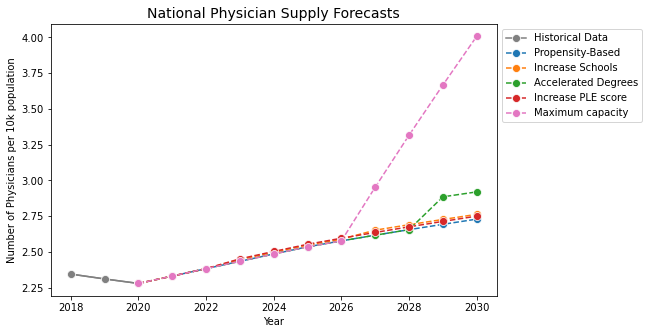

In [110]:
# FOR BASELINE

fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.lineplot(data=df_merge,
                  x='Year', y="Actual_x", label=None, marker="o",
                  markersize=8, color='grey')
ax = sns.lineplot(data=df_merge,
                  x='Year', y="Actual_y", label="Historical Data",
                  marker="o", markersize=8, color='grey')
ax = sns.lineplot(data=df_merge,
                  x='Year', y='Propensity',
                  label='Propensity-Based',
                  marker='o', markersize=8,
                  linestyle='--',
                  color=sns.color_palette("tab10")[0])
ax = sns.lineplot(data=df_merge,
                  x='Year', y='Increase Schools',
                  label='Increase Schools',
                  marker='o', markersize=8,
                  linestyle='--',
                  color=sns.color_palette("tab10")[1])
ax = sns.lineplot(data=df_merge,
                  x='Year', y='Accelerated Degrees',
                  label='Accelerated Degrees',
                  marker='o', markersize=8,
                  linestyle='--',
                  color=sns.color_palette("tab10")[2])
ax = sns.lineplot(data=df_merge,
                  x='Year', y='Increase PLE score',
                  label='Increase PLE score',
                  marker='o', markersize=8,
                  linestyle='--',
                  color=sns.color_palette("tab10")[3])
ax = sns.lineplot(data=df_merge,
                  x='Year', y='Maximum capacity',
                  label='Maximum capacity',
                  marker='o', markersize=8,
                  linestyle='--',
                  color=sns.color_palette("tab10")[6])

ax.set_title('National Physician Supply Forecasts', fontsize=14)
ax.set_ylabel('Number of Physicians per 10k population')
ax.set_xlabel('Year')
ax.legend(bbox_to_anchor=(1, 1));
# plt.savefig('National_Supply_Forecast_per10k_max_withacc.png', dpi=300, bbox_inches='tight');

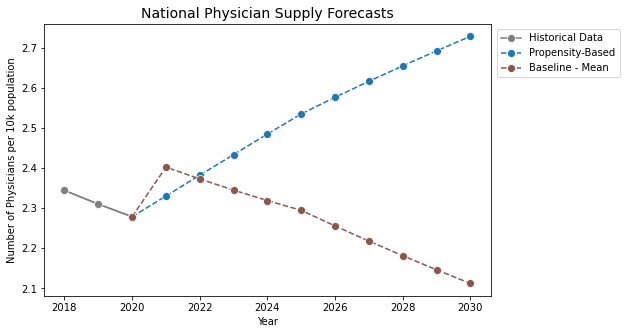

In [111]:
# FOR BASELINE

fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.lineplot(data=df_merge,
                  x='Year', y="Actual_x", label=None, marker="o",
                  markersize=8, color='grey')
ax = sns.lineplot(data=df_merge,
                  x='Year', y="Actual_y", label="Historical Data",
                  marker="o", markersize=8, color='grey')
ax = sns.lineplot(data=df_merge,
                  x='Year', y='Supply_Forecast',
                  label='Propensity-Based',
                  marker='o', markersize=8,
                  linestyle='--',
                  color=sns.color_palette("tab10")[0])
ax = sns.lineplot(data=df_merge,
                  x='Year', y='Average Historical Proportions', 
                  label='Baseline - Mean', marker="o",
                  markersize=8, linestyle='--',
                  color=sns.color_palette("tab10")[5])

ax.set_title('National Physician Supply Forecasts', fontsize=14)
ax.set_ylabel('Number of Physicians per 10k population')
ax.set_xlabel('Year')
ax.legend(bbox_to_anchor=(1.3, 1));
# plt.savefig('figures/National_Supply_Forecast_per10k_no scenario.png',
# dpi=300, bbox_inches='tight');